In [1]:
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_recall_curve
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, precision_recall_curve, precision_score, recall_score

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Enhancement Configuration
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

def augment_images(data_dir, class_name, augmented_dir, target_count):

    save_class_dir = os.path.join(augmented_dir, class_name)
    if not os.path.exists(save_class_dir):
        os.makedirs(save_class_dir)

    current_count = len(os.listdir(os.path.join(data_dir, class_name)))
    additional_count = target_count - current_count
    print(f"类别 '{class_name}' 当前有 {current_count} 张图像, 需要增加 {additional_count} 张图像。")
    
    if additional_count <= 0:
        print(f"类别 '{class_name}' 已经达到或超过目标数量。")
        return

    # Generate data-enhanced images
    generator = datagen.flow_from_directory(
        directory=data_dir,
        classes=[class_name],
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical',
        save_to_dir=save_class_dir,
        save_prefix='aug_',
        save_format='png',
        color_mode='rgb'  
    )
    
    num_batches = int(np.ceil(additional_count / generator.batch_size))
    
    for i in range(num_batches):
        images, _ = next(generator)
        # If a sufficient number of images have been generated, exit the loop
        if len(os.listdir(save_class_dir)) >= target_count:
            break
    print(f"类别 '{class_name}' 图像增强完成。")

# Original dataset directory
original_dataset_dir = r'C:\Users\FOMO\Desktop\MV\202018010315_MV_Coursework\images\wheat_leaf'
# Enhanced dataset directory
augmented_dataset_dir = r'C:\Users\FOMO\Desktop\MV\202018010315_MV_Coursework\images\augmented_dataset'
if not os.path.exists(augmented_dataset_dir):
    os.makedirs(augmented_dataset_dir)

# Data enhancement for each category separately
for class_name in ['healthy', 'unhealthy']:
    augment_images(original_dataset_dir, class_name, augmented_dataset_dir, 2000)

print("所有类别的图像增强完成。")

train/healthy: 1996 images
train/unhealthy: 2017 images
validation/healthy: 539 images
validation/unhealthy: 551 images
test/healthy: 288 images
test/unhealthy: 292 images


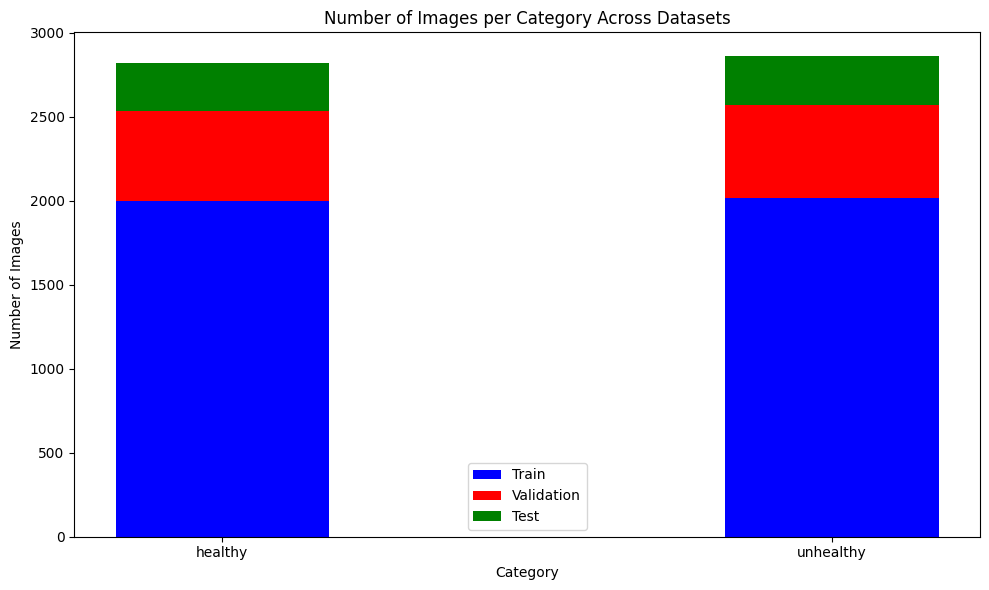

In [2]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

def split_dataset(original_dir, target_dir, train_ratio=0.85, val_ratio=0.1):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
        os.makedirs(os.path.join(target_dir, 'train'))
        os.makedirs(os.path.join(target_dir, 'validation'))
        os.makedirs(os.path.join(target_dir, 'test'))

    classes = [d for d in os.listdir(original_dir) if os.path.isdir(os.path.join(original_dir, d))]

    for cls in classes:
        os.makedirs(os.path.join(target_dir, 'train', cls), exist_ok=True)
        os.makedirs(os.path.join(target_dir, 'validation', cls), exist_ok=True)
        os.makedirs(os.path.join(target_dir, 'test', cls), exist_ok=True)

        all_images = os.listdir(os.path.join(original_dir, cls))
        np.random.shuffle(all_images)

        train_end = int(len(all_images) * train_ratio)
        val_end = train_end + int(len(all_images) * val_ratio)

        for i, img in enumerate(all_images):
            if i < train_end:
                subset = 'train'
            elif i < val_end:
                subset = 'validation'
            else:
                subset = 'test'

            src = os.path.join(original_dir, cls, img)
            dst = os.path.join(target_dir, subset, cls, img)
            shutil.copy(src, dst)

def count_images_in_subfolders(directory):
    counts = {}
    for subset in ['train', 'validation', 'test']:
        subset_path = os.path.join(directory, subset)
        for cls in os.listdir(subset_path):
            class_path = os.path.join(subset_path, cls)
            if os.path.isdir(class_path):
                count = len(os.listdir(class_path))
                counts[f"{subset}/{cls}"] = count
    return counts

def visualize_data_split(train_dir, validation_dir, test_dir):
    categories = set()
    data = {'train': {}, 'validation': {}, 'test': {}}

    for dataset, directory in zip(['train', 'validation', 'test'], [train_dir, validation_dir, test_dir]):
        for category in os.listdir(directory):
            category_path = os.path.join(directory, category)
            if os.path.isdir(category_path):
                categories.add(category)
                data[dataset][category] = len(os.listdir(category_path))

    categories = sorted(list(categories))
    
    train_counts = [data['train'].get(category, 0) for category in categories]
    val_counts = [data['validation'].get(category, 0) for category in categories]
    test_counts = [data['test'].get(category, 0) for category in categories]

    bar_width = 0.35
    index = np.arange(len(categories))

    plt.figure(figsize=(10, 6))

    plt.bar(index, train_counts, bar_width, label='Train', color='b')
    plt.bar(index, val_counts, bar_width, bottom=train_counts, label='Validation', color='r')
    plt.bar(index, test_counts, bar_width, bottom=np.array(train_counts) + np.array(val_counts), label='Test', color='g')

    plt.xlabel('Category')
    plt.ylabel('Number of Images')
    plt.title('Number of Images per Category Across Datasets')
    plt.xticks(index, categories)
    plt.legend()

    plt.tight_layout()
    plt.show()

augmented_dataset_dir = r'C:\Users\FOMO\Desktop\MV\202018010315_MV_Coursework\images\augmented_dataset'
splited_dataset_dir = r"C:\Users\FOMO\Desktop\MV\202018010315_MV_Coursework\images\splited_dataset"

split_dataset(augmented_dataset_dir, splited_dataset_dir)

counts = count_images_in_subfolders(splited_dataset_dir)
for key, count in counts.items():
    print(f"{key}: {count} images")

train_dir = os.path.join(splited_dataset_dir, 'train')
validation_dir = os.path.join(splited_dataset_dir, 'validation')
test_dir = os.path.join(splited_dataset_dir, 'test')

visualize_data_split(train_dir, validation_dir, test_dir)

Found 4013 images belonging to 2 classes.
Found 1090 images belonging to 2 classes.
Found 580 images belonging to 2 classes.


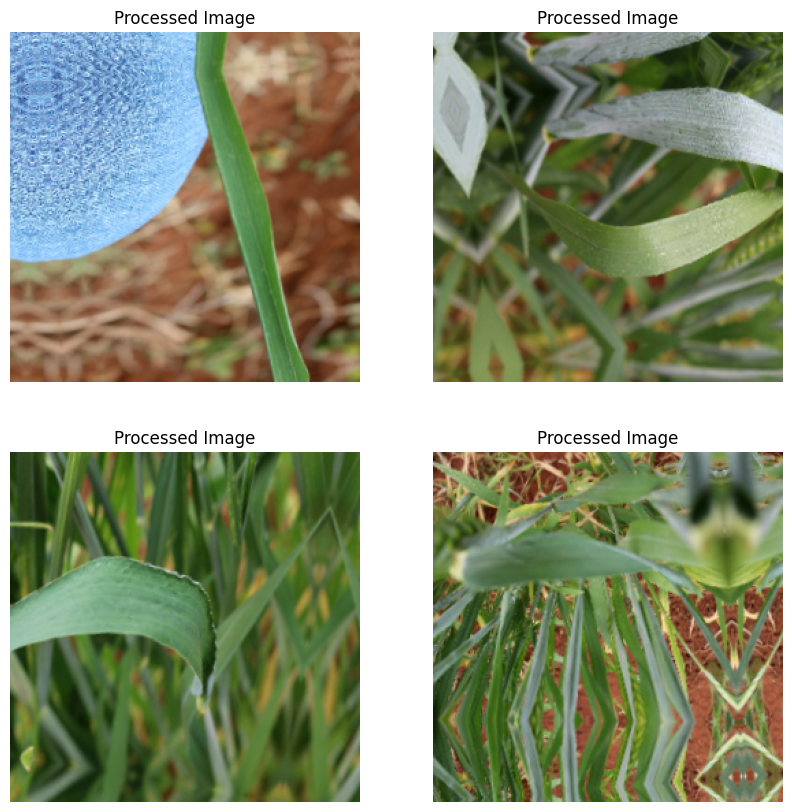

In [3]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

def preprocess_wheat_leaves_data():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,  # Wheat leaves can appear in any direction
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.1,
        shear_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,  # Up and down turning of wheat leaves
        fill_mode='reflect'  # Use reflection
    )
    val_test_datagen = ImageDataGenerator(
        rescale=1./255,
    )
    return train_datagen, val_test_datagen

# Create a function to save an image to a specified directory
def load_wheat_leaves_datasets(train_datagen, val_test_datagen, batch_size=32, target_size=(256,256)):
    train_dir = r"C:\Users\FOMO\Desktop\MV\202018010315_MV_Coursework\images\splited_dataset\train"
    val_dir = r"C:\Users\FOMO\Desktop\MV\202018010315_MV_Coursework\images\splited_dataset\validation"
    test_dir = r"C:\Users\FOMO\Desktop\MV\202018010315_MV_Coursework\images\splited_dataset\test"

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical', 
        color_mode='rgb'
    )

    validation_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='rgb'
    )

    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='rgb'
    )

    return train_generator, validation_generator, test_generator

train_datagen, val_test_datagen = preprocess_wheat_leaves_data()
train_generator, validation_generator, test_generator = load_wheat_leaves_datasets(train_datagen, val_test_datagen)

# Extract a batch of images and labels from train_generator
batch_images, batch_labels = next(train_generator)

# Setting the number of images to visualize
num_images = 4

plt.figure(figsize=(10, 10))

for i in range(num_images):
    plt.subplot(2, 2, i + 1)
    plt.imshow(batch_images[i])
    plt.title('Processed Image')
    plt.axis('off')

plt.show()

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models

def resnet_block(input_tensor, filters, kernel_size=3, stride=2, conv_shortcut=True):
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding="same")(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(filters, kernel_size, padding="same")(x)
    x = layers.BatchNormalization()(x)

    if conv_shortcut:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding="same")(input_tensor)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor

    x = layers.add([x, shortcut])
    x = layers.Activation("relu")(x)
    return x

def inception_block(input_tensor, filters):
    branch1 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(input_tensor)

    branch2 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(input_tensor)

    branch3 = layers.Conv2D(filters, (5, 5), padding='same', activation='relu')(input_tensor)

    branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_tensor)
    branch4 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(branch4)

    output = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)
    return output

def spatial_attention(input_tensor):
    kernel_size = 7
    avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(input_tensor)
    max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(input_tensor)
    concat = layers.concatenate([avg_pool, max_pool], axis=-1)
    attention = layers.Conv2D(1, kernel_size, padding='same', activation='sigmoid')(concat)
    return layers.multiply([input_tensor, attention])

def create_custom_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # ResNet and Inception Modules
    x = resnet_block(inputs, 64)
    x = resnet_block(x, 32)
    x = resnet_block(x, 32)
    # Spatial attention mechanisms
    x = spatial_attention(x)

    x = inception_block(x, 32)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = inception_block(x, 32)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = inception_block(x, 32)
    # Spatial attention mechanisms
    x = spatial_attention(x)
    # Global average pooling and output layer
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)  # Add dropout
    outputs = layers.Dense(2, activation='softmax')(x) 

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [5]:
def categorical_crossentropy(y_true, y_pred):
    K = tf.keras.backend
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    loss = -K.sum(y_true * K.log(y_pred), axis=-1)
    return loss

def accuracy(y_true, y_pred):
    predicted_classes = tf.argmax(y_pred, axis=1)
    true_classes = tf.argmax(y_true, axis=1)

    accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted_classes, true_classes), tf.float32))
    return accuracy

In [6]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = create_custom_model((256,256, 3)) 
model.summary()

# 编译模型
learning_rate = 0.01 
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss=categorical_crossentropy,
              metrics=[accuracy, Precision(name='precision'), Recall(name='recall')]
)

# Creating Callback Functions
early_stopping = EarlyStopping(monitor='val_loss', patience=10)  # Stop training when val_loss doesn't improve for 10 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)  # When val_loss does not improve in 5 epochs, the learning rate is reduced to 20% of the original, down to 0.0001

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [7]:
# training model
history = model.fit(
    train_generator,
    epochs=40,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]  
)

Epoch 1/40
126/126 [==============================] - 64s 441ms/step - loss: 0.5755 - accuracy: 0.7083 - precision: 0.7094 - recall: 0.7094 - val_loss: 0.9718 - val_accuracy: 0.4277 - val_precision: 0.4257 - val_recall: 0.4257 - lr: 0.0100
Epoch 2/40
126/126 [==============================] - 53s 424ms/step - loss: 0.4385 - accuracy: 0.8166 - precision: 0.8161 - recall: 0.8161 - val_loss: 0.7113 - val_accuracy: 0.6045 - val_precision: 0.6073 - val_recall: 0.6073 - lr: 0.0100
Epoch 3/40
126/126 [==============================] - 54s 425ms/step - loss: 0.4260 - accuracy: 0.8252 - precision: 0.8251 - recall: 0.8251 - val_loss: 1.3609 - val_accuracy: 0.6152 - val_precision: 0.6183 - val_recall: 0.6183 - lr: 0.0100
Epoch 4/40
126/126 [==============================] - 54s 426ms/step - loss: 0.3634 - accuracy: 0.8542 - precision: 0.8550 - recall: 0.8550 - val_loss: 0.4920 - val_accuracy: 0.7473 - val_precision: 0.7541 - val_recall: 0.7541 - lr: 0.0100
Epoch 5/40
126/126 [====================

In [8]:
evaluation_result = model.evaluate(test_generator, steps=5)

5/5 [==============================] - 1s 105ms/step - loss: 0.0831 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688


In [9]:
model.save('try/model_try2.h5')  # Save Model
model_path = 'try/model_try2.h5'

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [11]:
loaded_model = load_model(model_path, custom_objects={'categorical_crossentropy': categorical_crossentropy, 'modified_accuracy': accuracy})

all_images = []
all_true_labels = []

for _ in range(test_generator.samples // test_generator.batch_size):
    images, true_labels = next(test_generator)
    all_images.extend(images)
    all_true_labels.extend(true_labels)

all_images = np.array(all_images)
all_true_labels = np.argmax(np.array(all_true_labels), axis=1)

predictions = loaded_model.predict(all_images)
predicted_labels = np.argmax(predictions, axis=1)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']

epochs = range(len(acc))

18/18 [==============================] - 1s 33ms/step


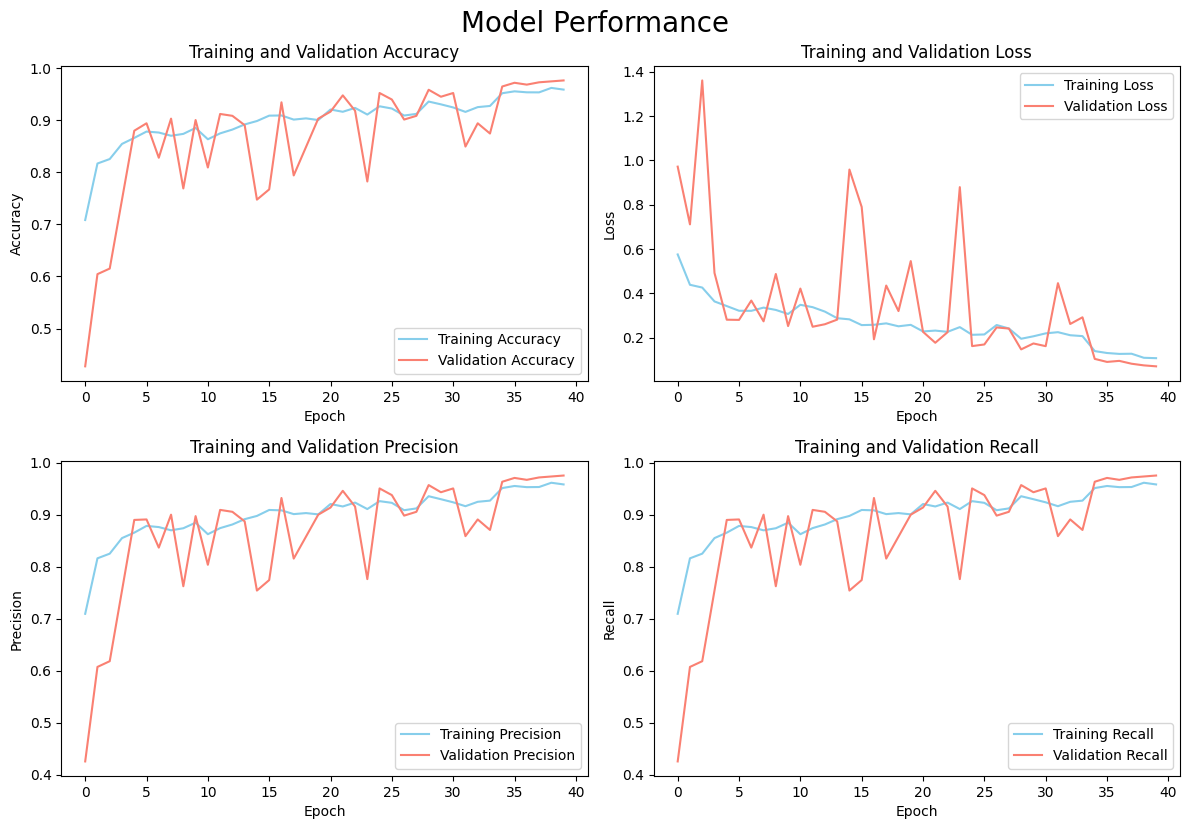

In [12]:
plt.figure(figsize=(12, 12))

# Accuracy
plt.subplot(3, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy', color='skyblue')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='salmon')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(3, 2, 2)
plt.plot(epochs, loss, label='Training Loss', color='skyblue')
plt.plot(epochs, val_loss, label='Validation Loss', color='salmon')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Precision
plt.subplot(3, 2, 3)
plt.plot(epochs, precision, label='Training Precision', color='skyblue')
plt.plot(epochs, val_precision, label='Validation Precision', color='salmon')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(3, 2, 4)
plt.plot(epochs, recall, label='Training Recall', color='skyblue')
plt.plot(epochs, val_recall, label='Validation Recall', color='salmon')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch',)
plt.ylabel('Recall')
plt.legend()

plt.suptitle("Model Performance", fontsize=20)
plt.tight_layout()
plt.show()

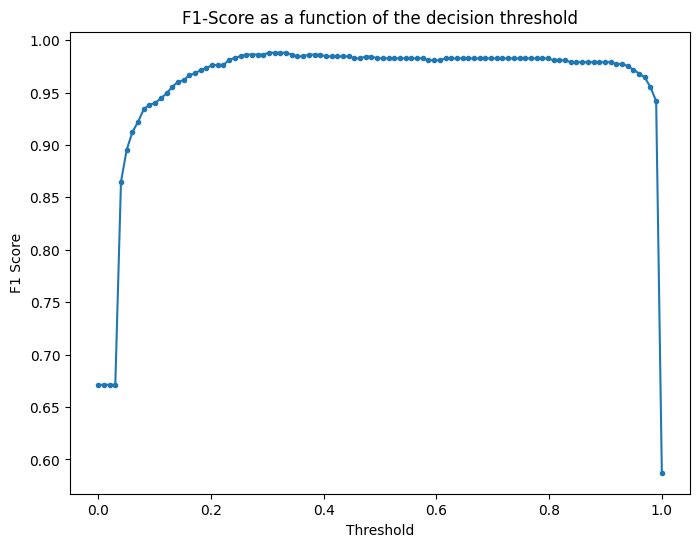

In [13]:
thresholds = np.linspace(0, 1, 100)
f1_scores = []

for thresh in thresholds:
    predicted_labels_thresh = (predictions[:, 1] >= thresh).astype(int)

    precision = precision_score(all_true_labels, predicted_labels_thresh, zero_division=0)
    recall = recall_score(all_true_labels, predicted_labels_thresh)

    if precision + recall == 0:
        f1_scores.append(0)
    else:
        f1 = 2 * (precision * recall) / (precision + recall)
        f1_scores.append(f1)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores, marker='.')
plt.title('F1-Score as a function of the decision threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.show()

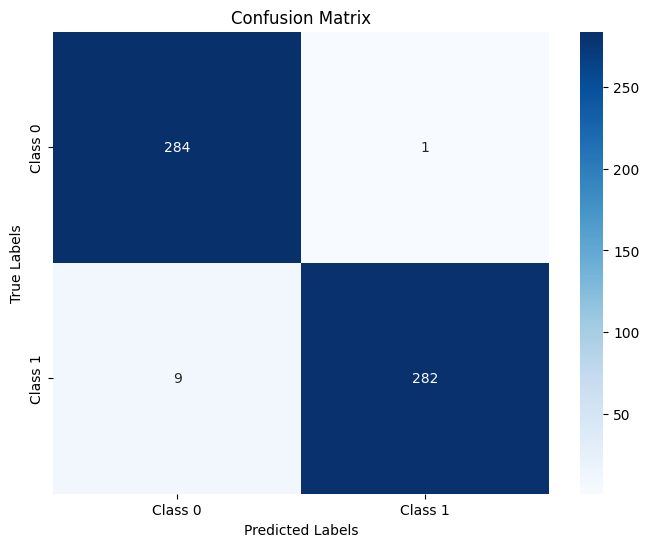

In [14]:
conf_matrix = confusion_matrix(all_true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

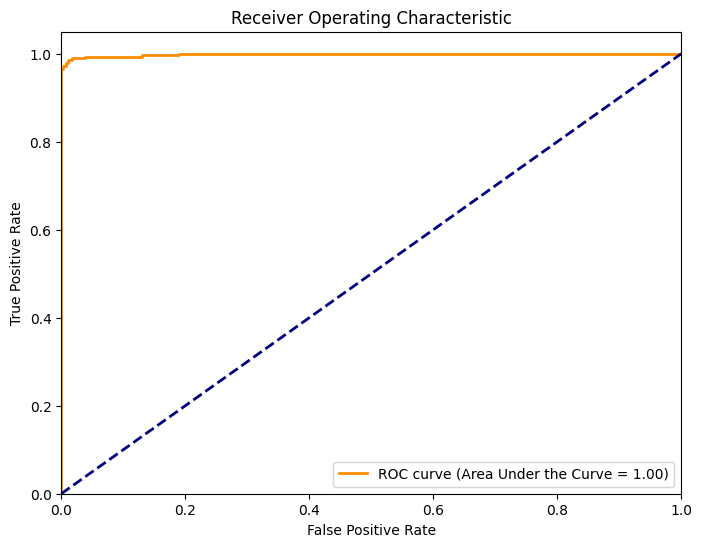

In [15]:
fpr, tpr, thresholds = roc_curve(all_true_labels, predictions[:, 1])  
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (Area Under the Curve = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

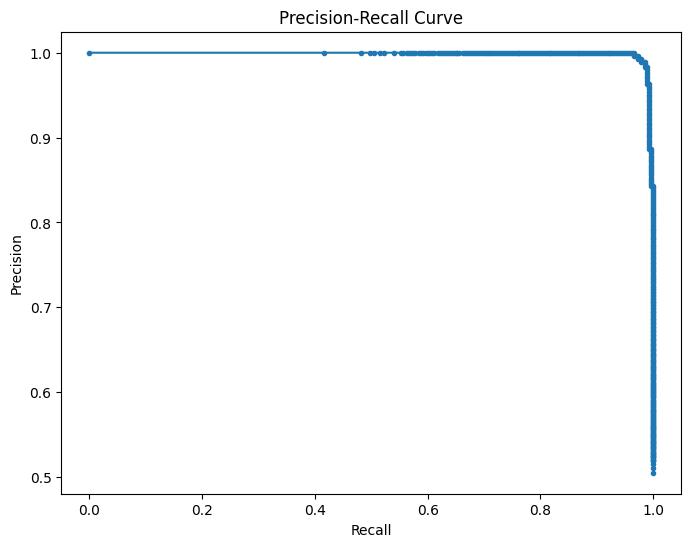

In [16]:
precision, recall, _ = precision_recall_curve(all_true_labels, predictions[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [17]:
thresholds = np.linspace(0, 1, 100)
sensitivity_scores = []
specificity_scores = []

for thresh in thresholds:
    predicted_labels_thresh = (predictions[:, 1] >= thresh).astype(int)

    tn, fp, fn, tp = confusion_matrix(all_true_labels, predicted_labels_thresh).ravel()

    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

    sensitivity_scores.append(sensitivity)
    specificity_scores.append(specificity)

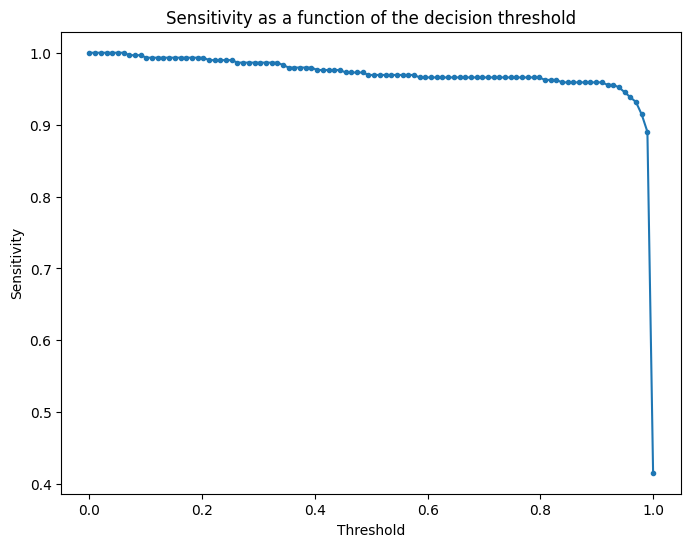

In [18]:
plt.figure(figsize=(8, 6))
plt.plot(thresholds, sensitivity_scores, marker='.')
plt.title('Sensitivity as a function of the decision threshold')
plt.xlabel('Threshold')
plt.ylabel('Sensitivity')
plt.show()

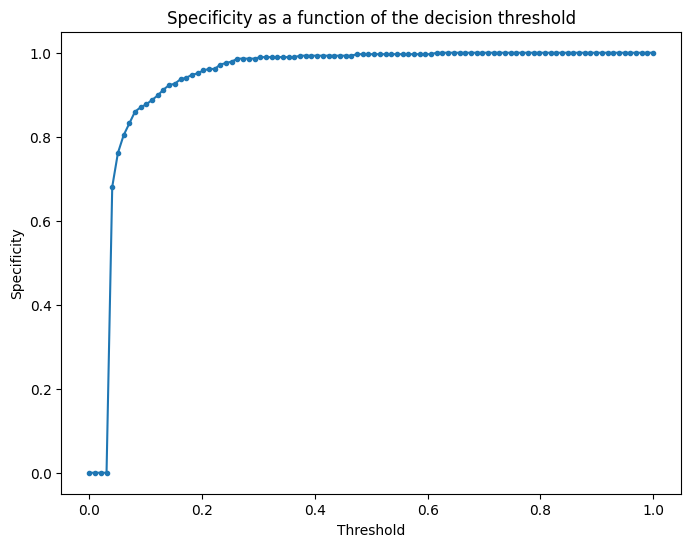

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(thresholds, specificity_scores, marker='.')
plt.title('Specificity as a function of the decision threshold')
plt.xlabel('Threshold')
plt.ylabel('Specificity')
plt.show()

In [20]:
cm = confusion_matrix(all_true_labels, predicted_labels)
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
precision = precision_score(all_true_labels, predicted_labels)
recall = recall_score(all_true_labels, predicted_labels)
f1 = f1_score(all_true_labels, predicted_labels)
auc = roc_auc_score(all_true_labels, predictions[:, 1]) if predictions is not None else "N/A"

In [21]:
print("Image Classification Report:")
print(classification_report(all_true_labels, predicted_labels))
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC: {auc}")
print("Confusion Matrix:")
print(cm)

Image Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       285
           1       1.00      0.97      0.98       291

    accuracy                           0.98       576
   macro avg       0.98      0.98      0.98       576
weighted avg       0.98      0.98      0.98       576

Sensitivity: 0.97
Specificity: 1.00
Precision: 1.00
Recall: 0.97
F1 Score: 0.98
AUC: 0.9985651413757762
Confusion Matrix:
[[284   1]
 [  9 282]]
